In [1]:
import torch
import torchvision
import numpy as np
from PIL import Image
import os
from glob import glob
import cv2
import os
import time

In [2]:
image_dir = 'DanishTeam_Segmentation/Training/imgs/'
mask_dir = 'DanishTeam_Segmentation/Training/masks/'

In [3]:
class CustomDataset(torch.utils.data.Dataset):
  def __init__(self, image_dir, mask_dir, mask_suffix='', transform=None):
    self.image_dir = image_dir
    self.mask_dir = mask_dir
    self.mask_suffix = mask_suffix

    if transform == None:
      self.transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])
    else: 
      self.transform = transform
    self.ids = [os.path.splitext(file)[0] for file in os.listdir(image_dir)
                    if not file.startswith('.') and not '20210305' in file]

  def __getitem__(self, i):
    basename = self.ids[i]

    mask_file = glob(self.mask_dir + basename + self.mask_suffix + '.*')
    img_file = glob(self.image_dir + basename + '.*')

    mask = cv2.imread(mask_file[0])
    img = cv2.imread(img_file[0]) 

    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    img = self.transform(img)
    mask = self.transform(mask)
    base_array = torch.zeros_like(mask[0])
    base_array[mask[0] > 0.] = 1  
    base_array = base_array.reshape(1, base_array.shape[0], base_array.shape[1])

    return img, base_array

  def __len__(self):
    return len(self.ids)

In [4]:
dataset = CustomDataset(image_dir, mask_dir)

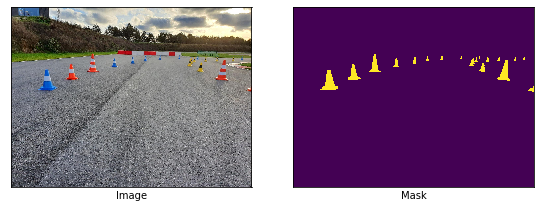

In [5]:
import matplotlib.pyplot as plt

def plot_class_masks(item: np.ndarray) -> None:
    """Plot a particular view of the true vs predicted segmentation.

    This function separates each class into its own image and
    does not perform any thresholding.

    Parameters:
        y_true: True segmentation (image_shape, num_classes).
        y_predicted: Predicted segmentation (image_shape, num_classes).
            If y_predicted is not provided, only the true values are displayed.
    """
    num_rows = 1

    num_columns = 2
    fig, axes = plt.subplots(num_rows, num_columns, figsize=(num_columns * 4, num_rows * 4))
    axes = axes.reshape(-1, num_columns)
    plt.tight_layout()
    
    axes[0, 0].imshow(item[0].squeeze().permute(1,2,0))
    axes[0, 0].set_xlabel("Image")
    axes[0, 0].axes.set_xticks([])
    axes[0, 0].axes.set_yticks([])
    axes[0, 1].imshow(item[1].squeeze())
    axes[0, 1].set_xlabel("Mask")
    axes[0, 1].axes.set_xticks([])
    axes[0, 1].axes.set_yticks([])

    plt.show()

plot_class_masks(dataset[100])

In [6]:
def build_dataset(image_dir='DanishTeam_Segmentation/Training/imgs/', \
                      mask_dir='DanishTeam_Segmentation/Training/masks/'):
    
    dataset = CustomDataset(image_dir, mask_dir)
    
    tsplit = 0.15
    tsize = int(len(dataset)*tsplit)
    indices = torch.randperm(len(dataset)).tolist()

    train = torch.utils.data.Subset(dataset, indices[:-tsize])
    test = torch.utils.data.Subset(dataset, indices[-tsize:])

    train_loader = torch.utils.data.DataLoader(
      train,
      batch_size=1,
      shuffle=True,
      num_workers=0
    )

    test_loader = torch.utils.data.DataLoader(
        test,
        batch_size=1,
        shuffle=True,
        num_workers=0
    )
    
    return train_loader, test_loader

In [7]:
import torch.nn as nn
import torch.nn.functional as F
import brevitas.nn as qnn

class ContextGuidedBlock(nn.Module):
    def __init__(self, in_channels, out_channels, dilation=2, reduction=16, down=False,
                 residual=True, norm_layer=nn.BatchNorm2d, bit_width=3, **kwargs):
        super(ContextGuidedBlock, self).__init__()
        inter_channels = out_channels // 2 if not down else out_channels
        if down:
            self.conv = _ConvBNPReLU(in_channels, inter_channels, 3, 2, 1, norm_layer=norm_layer, bit_width=bit_width, **kwargs)
            self.reduce = qnn.QuantConv2d(inter_channels * 2, out_channels, 1, bias=False, weight_bit_width=bit_width)
        else:
            self.conv = _ConvBNPReLU(in_channels, inter_channels, 1, 1, 0, norm_layer=norm_layer, bit_width=bit_width, **kwargs)
            self.reduce = nn.Identity()
        self.f_loc = _ChannelWiseConv(inter_channels, inter_channels, bit_width=bit_width, **kwargs)
        self.f_sur = _ChannelWiseConv(inter_channels, inter_channels, dilation, bit_width=bit_width, **kwargs)
        self.bn = norm_layer(inter_channels * 2)
        self.prelu = nn.PReLU(inter_channels * 2)
        self.f_glo = _FGlo(out_channels, reduction, bit_width=bit_width, **kwargs)
        self.down = down
        self.residual = residual

    def forward(self, x):
        out = self.conv(x)
        loc = self.f_loc(out)
        sur = self.f_sur(out)

        joi_feat = torch.cat([loc, sur], dim=1)
        joi_feat = self.prelu(self.bn(joi_feat))
        if self.down:
            joi_feat = self.reduce(joi_feat)

        out = self.f_glo(joi_feat)
        if self.residual:
            out = out + x
            
        return out


In [8]:
class _ConcatInjection(nn.Module):
    def __init__(self, in_channels, norm_layer=nn.BatchNorm2d, **kwargs):
        super(_ConcatInjection, self).__init__()
        self.bn = norm_layer(in_channels)
        self.prelu = nn.PReLU(in_channels)

    def forward(self, x1, x2):
        out = torch.cat([x1, x2], dim=1)
        out = self.bn(out)
        out = self.prelu(out)
        return out

In [9]:
class _InputInjection(nn.Module):
    def __init__(self, ratio):
        super(_InputInjection, self).__init__()
        self.pool = nn.ModuleList()
        for i in range(0, ratio):
            self.pool.append(nn.AvgPool2d(3, 2, 1))

    def forward(self, x):
        for pool in self.pool:
            x = pool(x)
        return x

In [10]:
class _FGlo(nn.Module):
    def __init__(self, in_channels, reduction=16, bit_width=3, **kwargs):
        super(_FGlo, self).__init__()
        self.gap = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            qnn.QuantLinear(in_channels, in_channels // reduction, bias=True, weight_bit_width=bit_width),
            nn.ReLU(True),
            qnn.QuantLinear(in_channels // reduction, in_channels, bias=True, weight_bit_width=bit_width),
            nn.Sigmoid())

    def forward(self, x):
        n, c, _, _ = x.size()
        out = self.gap(x).view(n, c)
        out = self.fc(out).view(n, c, 1, 1)
        return x * out

In [11]:
class _ChannelWiseConv(nn.Module):
    def __init__(self, in_channels, out_channels, dilation=1, bit_width=3, **kwargs):
        super(_ChannelWiseConv, self).__init__()
        self.conv = qnn.QuantConv2d(in_channels, out_channels, 3, 1, dilation, dilation, groups=in_channels, bias=False, weight_bit_width=bit_width)

    def forward(self, x):
        x = self.conv(x)
        return x

In [12]:
class _ConvBNPReLU(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0,
                 dilation=1, groups=1, norm_layer=nn.BatchNorm2d, bit_width=3, **kwargs):
        super(_ConvBNPReLU, self).__init__()
        self.conv = qnn.QuantConv2d(in_channels, out_channels, kernel_size, stride, padding, dilation, groups, bias=False, weight_bit_width=bit_width)
        self.bn = norm_layer(out_channels)
        self.prelu = nn.PReLU(out_channels)

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.prelu(x)
        return x

In [13]:
class _BNPReLU(nn.Module):
    def __init__(self, out_channels, norm_layer=nn.BatchNorm2d, **kwargs):
        super(_BNPReLU, self).__init__()
        self.bn = norm_layer(out_channels)
        self.prelu = nn.PReLU(out_channels)

    def forward(self, x):
        x = self.bn(x)
        x = self.prelu(x)
        return x

In [14]:
class CGNet(nn.Module):
    r"""CGNet
    Parameters
    ----------
    nclass : int
        Number of categories for the training dataset.
    norm_layer : object
        Normalization layer used in backbone network (default: :class:`nn.BatchNorm`;
        for Synchronized Cross-GPU BachNormalization).
    aux : bool
        Auxiliary loss.
    Reference:
        Tianyi Wu, et al. "CGNet: A Light-weight Context Guided Network for Semantic Segmentation."
        arXiv preprint arXiv:1811.08201 (2018).
    """

    def __init__(self, nclass=1, dropout_rate=0.2, backbone='', aux=False, jpu=False, pretrained_base=True, M=3, N=21, bit_width=3, **kwargs):
        super(CGNet, self).__init__()
        # stage 1
        self.stage1_0 = _ConvBNPReLU(3, 32, 3, 2, 1, bit_width=bit_width, **kwargs)
        self.stage1_1 = _ConvBNPReLU(32, 32, 3, 1, 1, bit_width=bit_width, **kwargs)
        self.stage1_2 = _ConvBNPReLU(32, 32, 3, 1, 1, bit_width=bit_width, **kwargs)

        self.sample1 = _InputInjection(1)
        self.sample2 = _InputInjection(2)
        self.bn_prelu1 = _BNPReLU(32 + 3, **kwargs)

        # stage 2
        self.stage2_0 = ContextGuidedBlock(32 + 3, 64, dilation=2, reduction=8, down=True, residual=False, bit_width=bit_width, **kwargs)
        self.stage2 = nn.ModuleList()
        for i in range(0, M - 1):
            self.stage2.append(ContextGuidedBlock(64, 64, dilation=2, reduction=8, bit_width=bit_width, **kwargs))
        self.bn_prelu2 = _BNPReLU(128 + 3, **kwargs)

        # stage 3
        self.stage3_0 = ContextGuidedBlock(128 + 3, 128, dilation=4, reduction=16, down=True, residual=False, bit_width=bit_width, **kwargs)
        self.stage3 = nn.ModuleList()
        for i in range(0, N - 1):
            self.stage3.append(ContextGuidedBlock(128, 128, dilation=4, reduction=16, bit_width=bit_width, **kwargs))
        self.bn_prelu3 = _BNPReLU(256, **kwargs)

        self.head = nn.Sequential(
            nn.Dropout2d(dropout_rate, False),
            nn.Conv2d(256, nclass, 1))

        self.__setattr__('exclusive', ['stage1_0', 'stage1_1', 'stage1_2', 'sample1', 'sample2',
                                       'bn_prelu1', 'stage2_0', 'stage2', 'bn_prelu2', 'stage3_0',
                                       'stage3', 'bn_prelu3', 'head'])

    def forward(self, x):
        size = x.size()[2:]
        # stage1
        out0 = self.stage1_0(x)
        out0 = self.stage1_1(out0)
        out0 = self.stage1_2(out0)
                
        inp1 = self.sample1(x)
        inp2 = self.sample2(x)

        # stage 2
        out0_cat = self.bn_prelu1(torch.cat([out0, inp1], dim=1))
        out1_0 = self.stage2_0(out0_cat)
        out1 = out1_0
        for layer in self.stage2:
            out1 = layer(out1)
        out1_cat = self.bn_prelu2(torch.cat([out1, out1_0, inp2], dim=1))

        # stage 3
        out2_0 = self.stage3_0(out1_cat)
        out2 = out2_0
        for layer in self.stage3:
            out2 = layer(out2)
        out2_cat = self.bn_prelu3(torch.cat([out2_0, out2], dim=1))

        out = self.head(out2_cat)
        out = F.interpolate(out, size, mode='bilinear', align_corners=True)
        out = torch.sigmoid(out)

        return out

In [7]:
from CGNetPy import CGNet

In [8]:
model = CGNet().double()
# device = torch.device('cuda')
# model = model#.to(device)
model(torch.rand((1, 3, 1088, 1456)).double())#.to(device))

CGNet initialised


tensor([[[[0.6489, 0.6298, 0.6103,  ..., 0.4938, 0.4932, 0.4926],
          [0.6502, 0.6303, 0.6100,  ..., 0.5111, 0.5117, 0.5123],
          [0.6515, 0.6308, 0.6097,  ..., 0.5284, 0.5302, 0.5320],
          ...,
          [0.5878, 0.5827, 0.5776,  ..., 0.5879, 0.5917, 0.5954],
          [0.6002, 0.5936, 0.5869,  ..., 0.5871, 0.5906, 0.5941],
          [0.6125, 0.6044, 0.5963,  ..., 0.5862, 0.5895, 0.5928]]]],
       dtype=torch.float64, grad_fn=<SigmoidBackward0>)

In [16]:
import wandb
wandb.login()
wandb.init(project="CGNet-Cones")

wandb: Currently logged in as: lilpharaoh11. Use `wandb login --relogin` to force relogin


In [17]:
sweep_config = {
    'method': 'random',
    'metric': {'goal':'minimize', 'name': 'test_loss'},
    'parameters': {
        'dropout': {'values': [0.1, 0.15, 0.2, 0.25, 0.3]},
        'lr': {'values': [0.0005, 0.00075, 0.001, 0.00125, 0.0015, 0.00175, 0.002]},
        #'optimizer': {'values': ['sgd', 'adam']},
        'stage2_layers': {'values': [2, 3, 4, 5]},
        'stage3_layers': {'values': [15, 21,  27]},
        'bit_width': {'values': [2, 3, 8, 16]},
        'epochs': {'value': 1}
    }
}

In [18]:
import pprint

pprint.pprint(sweep_config)

{'method': 'random',
 'metric': {'goal': 'minimize', 'name': 'test_loss'},
 'parameters': {'bit_width': {'values': [2, 3, 8, 16]},
                'dropout': {'values': [0.1, 0.15, 0.2, 0.25, 0.3]},
                'epochs': {'value': 1},
                'lr': {'values': [0.0005,
                                  0.00075,
                                  0.001,
                                  0.00125,
                                  0.0015,
                                  0.00175,
                                  0.002]},
                'stage2_layers': {'values': [2, 3, 4, 5]},
                'stage3_layers': {'values': [15, 21, 27]}}}


In [19]:
sweep_id = wandb.sweep(sweep_config, project="CGNet-Cones")

Create sweep with ID: lbyczs4c
Sweep URL: https://wandb.ai/lilpharaoh11/CGNet-Cones/sweeps/lbyczs4c


In [20]:
def build_network(stage2_layers=3, stage3_layers=21, dropout_rate=0.2, bit_width=3):
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    model = CGNet(dropout_rate=dropout_rate, M=stage2_layers, N=stage3_layers, bit_width=bit_width).double()
    
    return model.to(device)

In [21]:
def build_optimizer(model, optimizer, lr):
    from torch.optim import SGD, Adam
    if optimizer == 'sgd':
        optimizer = SGD(model.parameters(), lr=lr)
    elif optimizer == 'adam':
        optimizer = Adam(model.parameters(), lr=lr)
        
    return optimizer

In [22]:
def train_epoch(model, train_loader, test_loader, optimizer):
    loss_func = nn.BCELoss()
    print_every = 500
    step = 0
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    
    test_losses = []
    inference_times = []
    running_loss = 0        
    for image, label in train_loader:
        image, label = image.to(device), label.to(device)
        step += 1
        optimizer.zero_grad()
        output = model(torch.tensor(image).double())
        loss = loss_func(output.double(), torch.tensor(label).double())
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if step % print_every == 0:
            test_loss = 0
            accuracy = 0
            
            with torch.no_grad():
                model.eval()
                for image, label in test_loader:
                    output = model(torch.tensor(image).double())
                    test_loss += loss_func(output.double(), torch.tensor(label).double()).item()
                model.train()
                
                test_losses.append(test_loss / len(test_loader))
                
                start = time.time()
                _ = model(torch.rand((1, 3, 1088, 1456)).double())
                inference_times.append(time.time() - start)
                
    train_loss = running_loss / len(train_loader)
    
    return train_loss, test_losses[-1], inference_times[-1]

In [23]:
def train(config=None):
    with wandb.init(config=config):
        config = wandb.config
        model = build_network(config.stage2_layers, config.stage3_layers, config.dropout, config.bit_width)
        optimizer = build_optimizer(model, 'adam', config.lr)
        train_loader, test_loader = build_dataset()
        
        for epoch in range(config.epochs):
            train_loss, test_loss, inference_time = train_epoch(model, train_loader, test_loader, optimizer)
            wandb.log({
                    'train_loss': train_loss,
                    'test_loss': test_loss,
                    'inference_time': inference_time,
                })

In [25]:
torch.device('cuda:0')

device(type='cuda', index=0)

In [33]:
wandb.agent(sweep_id, train, count=20)

wandb: Agent Starting Run: de6fovf2 with config:
wandb: 	bit_width: 8
wandb: 	dropout: 0.1
wandb: 	epochs: 1
wandb: 	lr: 0.002
wandb: 	stage2_layers: 2
wandb: 	stage3_layers: 15


/tmp/ipykernel_387182/2463337846.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  output = model(torch.tensor(image).double())
/tmp/ipykernel_387182/2463337846.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss = loss_func(output.double(), torch.tensor(label).double())
wandb: Ctrl + C detected. Stopping sweep.


In [37]:
model.load_state_dict(torch.load('weights/CGNetWeights'))

<All keys matched successfully>

In [42]:
EPOCHS = 2
optimizer = torch.optim.Adam(model.parameters(), lr=0.0015)
loss_func = nn.BCELoss()
print_every = 60
step = 0
test_losses, train_losses = [], []
checkpoint = True

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

for e in range(EPOCHS):
    running_loss = 0        
    for image, label in train_loader:
        image, label = image.to(device), label.to(device)
        step += 1
        optimizer.zero_grad()
        output = model(torch.tensor(image).double())
        loss = loss_func(output.double(), torch.tensor(label).double())
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if step % print_every == 0:
            test_loss = 0
            accuracy = 0
            
            with torch.no_grad():
                model.eval()
                for image, label in test_loader:
                    output = model(torch.tensor(image).double())
                    test_loss += loss_func(output.double(), torch.tensor(label).double())
                model.train()
                
                for g in optimizer.param_groups:
                    g['lr'] *= 0.98
                
                train_losses.append(running_loss/len(train_loader))
                test_losses.append(test_loss/len(test_loader))

                if not isinstance(checkpoint, bool): # checkpoint exists
                    if test_losses[-1] > test_losses[-2]*1.3:
                        model.load_state_dict(checkpoint)
                    else:
                        checkpoint = model.state_dict()
                else:
                    checkpoint = model.state_dict()
                
                print("Epoch: {}/{}.. ".format(e+1, EPOCHS),
                      "Training Loss: {:.3f}.. ".format(running_loss / print_every),
                      "Test Loss: {:.3f}.. ".format(test_losses[-1])) 
                
                running_loss = 0
                
print("Done Training...")

/tmp/ipykernel_205056/2826132557.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  output = model(torch.tensor(image).double())


In [27]:
for image, label in test_loader:
    print(image.shape, label.shape)
    break

torch.Size([1, 3, 1088, 1456]) torch.Size([1, 1, 1088, 1456])


In [32]:
if not os.path.isdir('weights'):
    os.mkdir('weights')
    
torch.save(model.state_dict(), 'weights/CGNetWeights')

/tmp/ipykernel_204838/40538839.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tensor_image = torch.tensor(image).double()


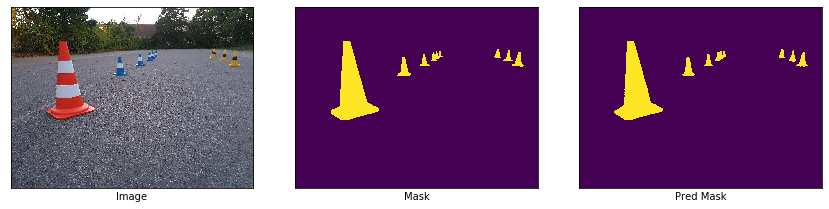

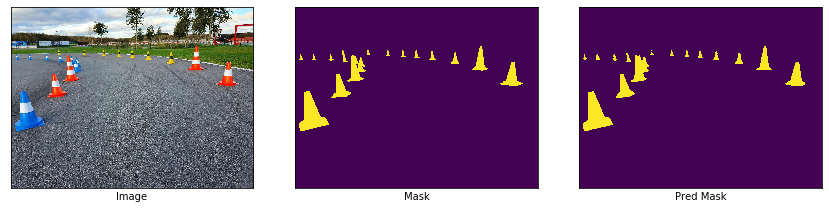

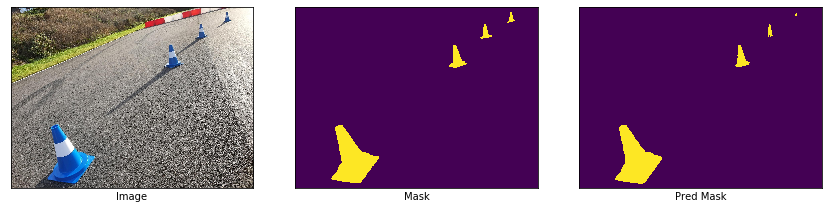

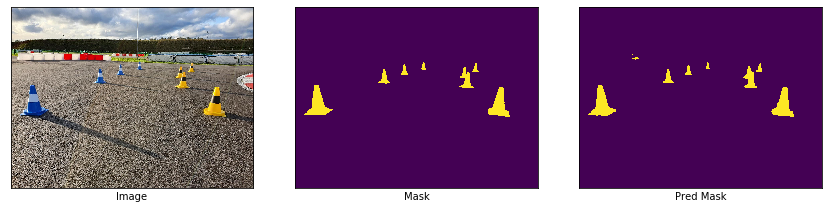

In [20]:
def display_pred_masks(model, image, label):
    num_rows = 1

    num_columns = 3
    fig, axes = plt.subplots(num_rows, num_columns, figsize=(num_columns * 4, num_rows * 4))
    axes = axes.reshape(-1, num_columns)
    plt.tight_layout()
    
    tensor_image = torch.tensor(image).double()
    tensor_image = tensor_image.reshape(1, *tensor_image.shape)
    output = model(tensor_image)
    
    axes[0, 0].imshow(image.squeeze().permute(1,2,0))
    axes[0, 0].set_xlabel("Image")
    axes[0, 0].axes.set_xticks([])
    axes[0, 0].axes.set_yticks([])
    axes[0, 1].imshow(label.squeeze())
    axes[0, 1].set_xlabel("Mask")
    axes[0, 1].axes.set_xticks([])
    axes[0, 1].axes.set_yticks([])
    
    base_array = np.zeros_like(output.detach().numpy())
    base_array[output > 0.5] = 1
    
    axes[0, 2].imshow(base_array.squeeze())
    axes[0, 2].set_xlabel("Pred Mask")
    axes[0, 2].axes.set_xticks([])
    axes[0, 2].axes.set_yticks([])

    plt.show()

k = 0
for image, label in train_loader:
    display_pred_masks(model, image[0], label[0])
    if k == 3:
        break
    else:
        k += 1

In [35]:
total_params = 0

for name, param in model.named_parameters():
    params = param.numel()
    print(name, params)
    total_params += params
    
print("Total Parameters : ", total_params)

stage1_0.conv.weight 864
stage1_0.bn.weight 32
stage1_0.bn.bias 32
stage1_0.prelu.weight 32
stage1_1.conv.weight 9216
stage1_1.bn.weight 32
stage1_1.bn.bias 32
stage1_1.prelu.weight 32
stage1_2.conv.weight 9216
stage1_2.bn.weight 32
stage1_2.bn.bias 32
stage1_2.prelu.weight 32
bn_prelu1.bn.weight 35
bn_prelu1.bn.bias 35
bn_prelu1.prelu.weight 35
stage2_0.conv.conv.weight 20160
stage2_0.conv.bn.weight 64
stage2_0.conv.bn.bias 64
stage2_0.conv.prelu.weight 64
stage2_0.reduce.weight 8192
stage2_0.f_loc.conv.weight 576
stage2_0.f_sur.conv.weight 576
stage2_0.bn.weight 128
stage2_0.bn.bias 128
stage2_0.prelu.weight 128
stage2_0.f_glo.fc.0.weight 512
stage2_0.f_glo.fc.0.bias 8
stage2_0.f_glo.fc.2.weight 512
stage2_0.f_glo.fc.2.bias 64
stage2.0.conv.conv.weight 2048
stage2.0.conv.bn.weight 32
stage2.0.conv.bn.bias 32
stage2.0.conv.prelu.weight 32
stage2.0.f_loc.conv.weight 288
stage2.0.f_sur.conv.weight 288
stage2.0.bn.weight 64
stage2.0.bn.bias 64
stage2.0.prelu.weight 64
stage2.0.f_glo.fc.0

In [36]:
model

CGNet(
  (stage1_0): _ConvBNPReLU(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (prelu): PReLU(num_parameters=32)
  )
  (stage1_1): _ConvBNPReLU(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (prelu): PReLU(num_parameters=32)
  )
  (stage1_2): _ConvBNPReLU(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (prelu): PReLU(num_parameters=32)
  )
  (sample1): _InputInjection(
    (pool): ModuleList(
      (0): AvgPool2d(kernel_size=3, stride=2, padding=1)
    )
  )
  (sample2): _InputInjection(
    (pool): ModuleList(
      (0): AvgPool2d(kernel_size=3, stride=2, padding=1)
      (1): A

In [24]:
def log_images(model, image, label):
    
    tensor_image = torch.tensor(image).double()
    tensor_image = tensor_image.reshape(1, *tensor_image.shape)
    output = model(tensor_image)
    
    base_array = np.zeros_like(output.detach().numpy())
    base_array[output > 0.5] = 1
    
    image = image.squeeze().permute(1,2,0)
    target = label.squeeze()
    output = base_array.squeeze()
    
    images = torchvision.utils.make_grid(image, target, output])
    
    wandb.log({
        'media': wandb.Image(images, caption='Image, Target, Output')
    })
    
for image, label in train_loader:
    log_images(model, image[0], label[0])
    break

/tmp/ipykernel_205056/848897156.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tensor_image = torch.tensor(image).double()


TypeError: tensor or list of tensors expected, got <class 'list'>